# Random Forest Regression

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import pytz
import os
import re

## Importing the dataset

In [2]:
csv_filename = '0x11b815efb8f581194ae79006d24e0d814b7697f6_WETH_USDT_0.05pct_last90d.csv'
dataset = pd.read_csv(csv_filename)

# Extrair feeTier do nome do arquivo (ex: '0.01pct' → 0.01)
match = re.search(r'_(\d*\.?\d+)pct', csv_filename)

if match:
    feeTier = float(match.group(1))
else:
    raise ValueError("❌ Não foi possível extrair feeTier do nome do arquivo.")

# Remover a coluna 'date' (não é usada como feature)
dataset = dataset.drop(columns=['date'])

# Substituir APY por APR como variável alvo
X = dataset.drop(columns=['dailyAPR']).values
y = dataset['dailyAPR'].values

## Training the Random Forest Regression model on the whole dataset

In [3]:
# Dividir em treino e teste (opcional, mas recomendado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

## Predicting a new result

In [4]:
y_pred = regressor.predict(X_test)

# Avaliação no conjunto de teste

In [5]:
print("📊 Avaliação no conjunto de teste:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

📊 Avaliação no conjunto de teste:
MSE: 5.555030636354354
R² Score: 0.9551289490774489


## Visualising the Random Forest Regression results (higher resolution)

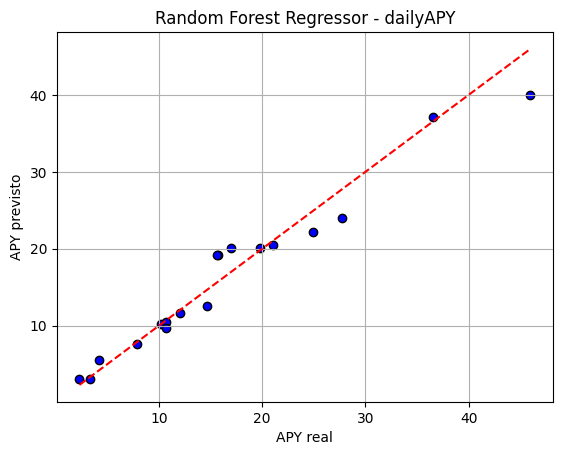

In [6]:
# Visualização: previsão vs valores reais (opcional)
plt.scatter(y_test, y_pred, color='blue', edgecolor='k')
plt.xlabel('APY real')
plt.ylabel('APY previsto')
plt.title('Random Forest Regressor - dailyAPY')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()

# Seção 5: Consulta à The Graph para APR atual do pool

In [7]:
# === 2. Extrair ID da pool a partir do nome do arquivo ===
pool_address = csv_filename.split('_')[0]

API_KEY = "54b3ae486458761ae740097bf7665918"

GRAPHQL_URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"

# === 3. Buscar dados atuais da pool ===
def fetch_latest_pool_data(pool_id):
    query = {
        "query": f"""
        {{
          poolDayDatas(
            first: 1,
            orderBy: date,
            orderDirection: desc,
            where: {{
              pool: "{pool_id}"
            }}
          ) {{
            feesUSD
            liquidity
            token0Price
            token1Price
            tvlUSD
            volumeUSD
          }}
        }}
        """
    }
    try:
        response = requests.post(GRAPHQL_URL, json=query)
        response.raise_for_status()
        data = response.json()

        # Verifica se há erros na resposta
        if "errors" in data:
            raise Exception(f"Erro no GraphQL: {data['errors']}")

        return data["data"]["poolDayDatas"]

    except Exception as e:
        print(f"❌ Erro ao buscar dados atuais da pool: {e}")
        return None

pool_data = fetch_latest_pool_data(pool_address)

if pool_data:
    print("✅ Dados atuais da pool encontrados com sucesso:")
    print(pool_data)
else:
    print("⚠️ Não foi possível recuperar os dados da pool.")

✅ Dados atuais da pool encontrados com sucesso:
[{'feesUSD': '33413.69441186820521153427008405718', 'liquidity': '1353038457552047611', 'token0Price': '0.0003727211590139727498915418978684829', 'token1Price': '2682.97083708765651141118439306236', 'tvlUSD': '75918611.08151139164811636431768877', 'volumeUSD': '66827388.82373641042306854016811438'}]


# Seção 6: aplicar o modelo

In [8]:
# Ordem correta: volumeUSD, liquidity, token0Price, token1Price, tvlUSD, totalValueLockedTokenAmount, fee

# === 4. Formatar entrada para o modelo ===

if pool_data:
    try:
        pool = pool_data[0]

        feeUSD = float(pool['feesUSD'])
        liquidity = float(pool['liquidity'])
        token0Price = float(pool['token0Price'])
        token1Price = float(pool['token1Price'])
        tvlUSD = float(pool['tvlUSD'])
        volumeUSD = float(pool['volumeUSD'])

        X_today = [[
            feeUSD,
            liquidity,
            token0Price,
            token1Price,
            tvlUSD,
            volumeUSD,
            feeTier  # Usando o valor extraído do nome do arquivo
        ]]

        apr_today = regressor.predict(X_today)
        print(f"\n📈 Estimativa de APR atual da pool {pool_address}: {apr_today[0]:.2f}%")

    except Exception as e:
        print(f"❌ Erro ao preparar dados para o modelo: {e}")
else:
    print("❌ Não foi possível obter dados atuais da pool.")



📈 Estimativa de APR atual da pool 0x11b815efb8f581194ae79006d24e0d814b7697f6: 14.77%
